(emcee_conversion)=
# Converting emcee objects to InferenceData

{class}`~arviz.InferenceData` is the central data format for ArviZ. `InferenceData` itself is just a container that maintains references to one or more {class}`xarray.Dataset`. 

Below are various ways to generate an `InferenceData` from emcee objects.

```{seealso}

- Conversion from Python, numpy or pandas objects
- {ref}`xarray_for_arviz` for an overview of `InferenceData` and its role within ArviZ. 
- {ref}`schema` describes the structure of `InferenceData` objects and the assumptions made by ArviZ to ease your exploratory analysis of Bayesian models.
```

We will start by importing the required packages and defining the model. The famous 8 school model.

In [1]:
import arviz as az
import numpy as np
import emcee

In [2]:
az.style.use("arviz-darkgrid")

In [3]:
J = 8
y_obs = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [4]:
def log_prior_8school(theta):
    mu, tau, eta = theta[0], theta[1], theta[2:]
    # Half-cauchy prior, hwhm=25
    if tau < 0:
        return -np.inf
    prior_tau = -np.log(tau ** 2 + 25 ** 2)
    prior_mu = -(mu / 10) ** 2  # normal prior, loc=0, scale=10
    prior_eta = -np.sum(eta ** 2)  # normal prior, loc=0, scale=1
    return prior_mu + prior_tau + prior_eta

def log_likelihood_8school(theta, y, s):
    mu, tau, eta = theta[0], theta[1], theta[2:]
    return -((mu + tau * eta - y) / s) ** 2

def lnprob_8school(theta, y, s):
    prior = log_prior_8school(theta)
    like_vect = log_likelihood_8school(theta, y, s)
    like = np.sum(like_vect)
    return like + prior

In [5]:
nwalkers = 40  # called chains in ArviZ
ndim = J + 2
draws = 1500
pos = np.random.normal(size=(nwalkers, ndim))
pos[:, 1] = np.absolute(pos[:, 1])
sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    lnprob_8school,
    args=(y_obs, sigma)
)
sampler.run_mcmc(pos, draws);

## Manually set variable names
This first example will show how to convert manually setting the variable names only, leaving everything else to ArviZ defaults.

In [6]:
# define variable names, it cannot be inferred from emcee
var_names = ["mu", "tau"] + ["eta{}".format(i) for i in range(J)]
idata1 = az.from_emcee(sampler, var_names=var_names)
idata1

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

ArviZ has stored the posterior variables with the provided names as expected, but it has also included other useful information in the `InferenceData` object. The log probability of each sample is stored in the `sample_stats` group under the name `lp` and all the arguments passed to the sampler as `args` have been saved in the `observed_data` group.

It can also be useful to perform a burn in cut to the MCMC samples (see :meth:`arviz.InferenceData.sel` for more details)

In [7]:
idata1.sel(draw=slice(100, None))

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

From an InferenceData object, ArviZ's native data structure, the {func}`posterior plot <arviz.plot_posterior>` of a few variables can be done in one line:

array([<AxesSubplot:title={'center':'mu'}>,
       <AxesSubplot:title={'center':'tau'}>,
       <AxesSubplot:title={'center':'eta4'}>], dtype=object)

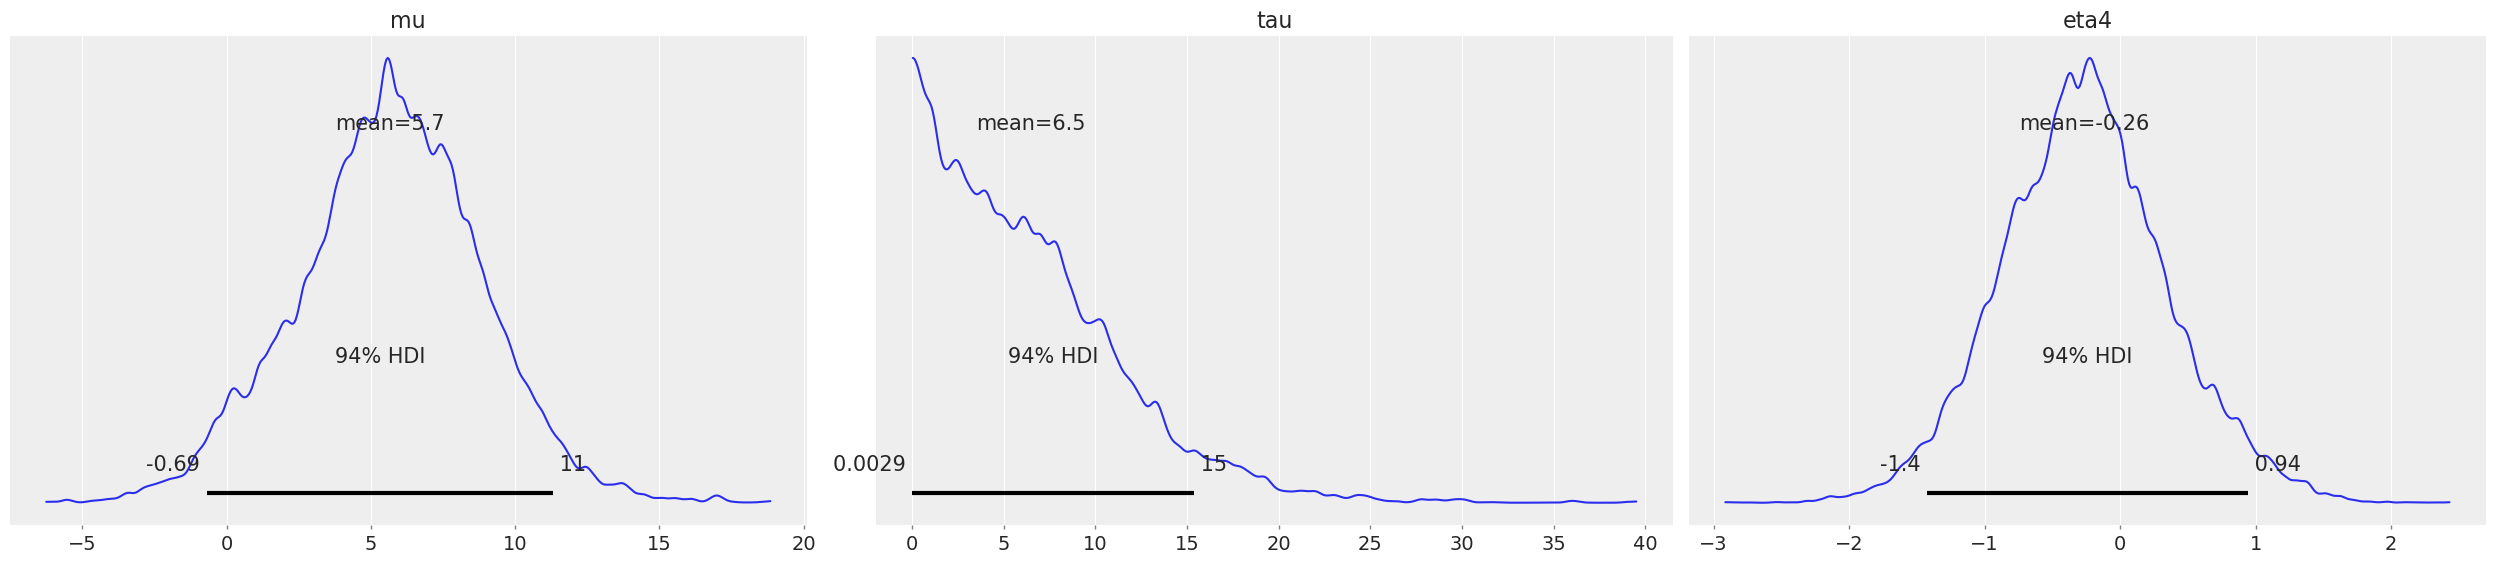

In [8]:
az.plot_posterior(idata1, var_names=["mu", "tau", "eta4"])

## Structuring the posterior as multidimensional variables

This way of calling ``from_emcee`` stores each `eta` as a different variable, called `eta#`, 
however, they are in fact different dimensions of the same variable. 
This can be seen in the code of the likelihood and prior functions, where `theta` is unpacked as:

    mu, tau, eta = theta[0], theta[1], theta[2:]
    
ArviZ has support for multidimensional variables, and there is a way to tell it how to split the variables like it was done in the likelihood and prior functions:

In [9]:
idata2 = az.from_emcee(sampler, slices=[0, 1, slice(2, None)])
idata2

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

After checking the default variable names, the trace of one dimension of eta can be plotted using ArviZ syntax:

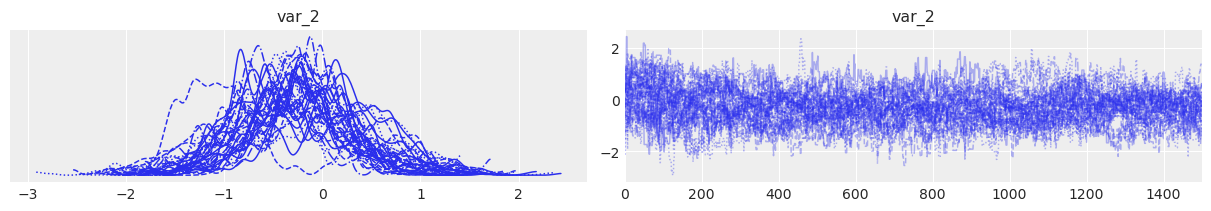

In [10]:
az.plot_trace(idata2, var_names=["var_2"], coords={"var_2_dim_0": 4});

## `blobs`: unlock sample stats, posterior predictive and miscellanea

Emcee does not store per-draw sample stats, however, it has a functionality called
blobs that allows to store any variable on a per-draw basis. It can be used
to store some sample_stats or even posterior_predictive data. 

You can modify the probability function to use this ``blobs`` functionality and store the pointwise log likelihood,
then rerun the sampler using the new function:

In [11]:
def lnprob_8school_blobs(theta, y, s):
    prior = log_prior_8school(theta)
    like_vect = log_likelihood_8school(theta, y, s)
    like = np.sum(like_vect)
    return like + prior, like_vect

sampler_blobs = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    lnprob_8school_blobs,
    args=(y_obs, sigma),
)
sampler_blobs.run_mcmc(pos, draws);

You can now use the `blob_names` argument to indicate how to store this blob-defined variable. As the group is not specified, it will go to sample_stats.
Note that the argument blob_names is added to the arguments covered in the previous examples and we are also introducing `coords` and `dims` arguments to show the power and flexibility of the converter. For more on `coords` and `dims` see `page_in_construction`.

In [12]:
dims = {"eta": ["school"], "log_likelihood": ["school"]}
idata3 = az.from_emcee(
    sampler_blobs,
    var_names = ["mu", "tau", "eta"],
    slices=[0, 1, slice(2,None)],
    blob_names=["log_likelihood"],
    dims=dims,
    coords={"school": range(8)}
)
idata3

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

## Multi-group blobs

You might even have more complicated blobs, each corresponding to a different group of the InferenceData object. Moreover, you can store the variables passed to the ``EnsembleSampler`` via the ``args`` argument in observed or constant data groups. This is shown in the example below:

In [13]:
sampler_blobs.blobs[0, 1]

array([-3.41541659e+00, -6.35964292e-01, -4.38888593e-02, -4.32716958e-01,
       -3.27623973e-03, -1.24760573e-02, -3.05547121e+00, -4.60634226e-01])

In [14]:
def lnprob_8school_blobs(theta, y, sigma):
    mu, tau, eta = theta[0], theta[1], theta[2:]
    prior = log_prior_8school(theta)
    like_vect = log_likelihood_8school(theta, y, sigma)
    like = np.sum(like_vect)
    # store pointwise log likelihood, useful for model comparison with az.loo or az.waic
    # and posterior predictive samples as blobs
    return like + prior, (like_vect, np.random.normal((mu + tau * eta), sigma))

sampler_blobs = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    lnprob_8school_blobs,
    args=(y_obs, sigma),
)
sampler_blobs.run_mcmc(pos, draws);

dims = {"eta": ["school"], "log_likelihood": ["school"], "y": ["school"]}
idata4 = az.from_emcee(
    sampler_blobs,
    var_names = ["mu", "tau", "eta"],
    slices=[0, 1, slice(2,None)],
    arg_names=["y","sigma"],
    arg_groups=["observed_data", "constant_data"],
    blob_names=["log_likelihood", "y"],
    blob_groups=["log_likelihood", "posterior_predictive"],
    dims=dims,
    coords={"school": range(8)}
)
idata4

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

This last version, which contains both observed data and posterior predictive can be used to plot posterior predictive checks:

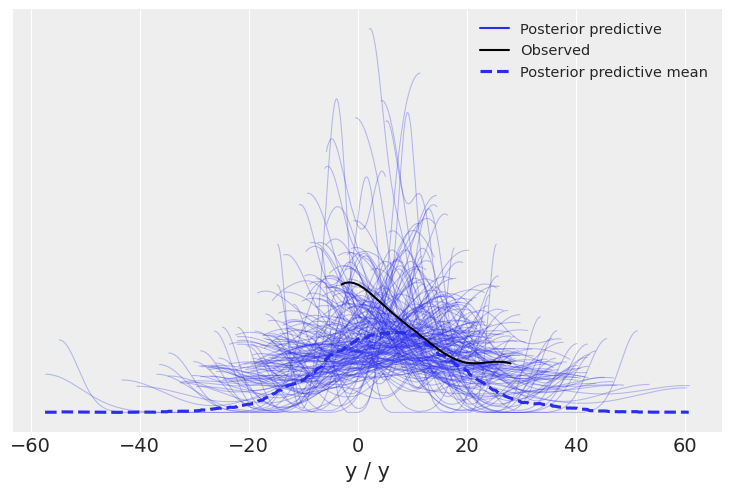

In [15]:
az.plot_ppc(idata4, var_names=["y"], alpha=0.3, num_pp_samples=200);

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Aug 30 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.27.0

emcee: 3.1.1
arviz: 0.11.2
numpy: None

Watermark: 2.1.0

